<a target="_blank" href="https://colab.research.google.com/drive/1MlWu2HBwmvvnXWyezwl93hyApHOufAQi?usp=sharing">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## 🕷️ Extract Houses Listing on Zillow with llama-index and ScrapegraphAI APIs

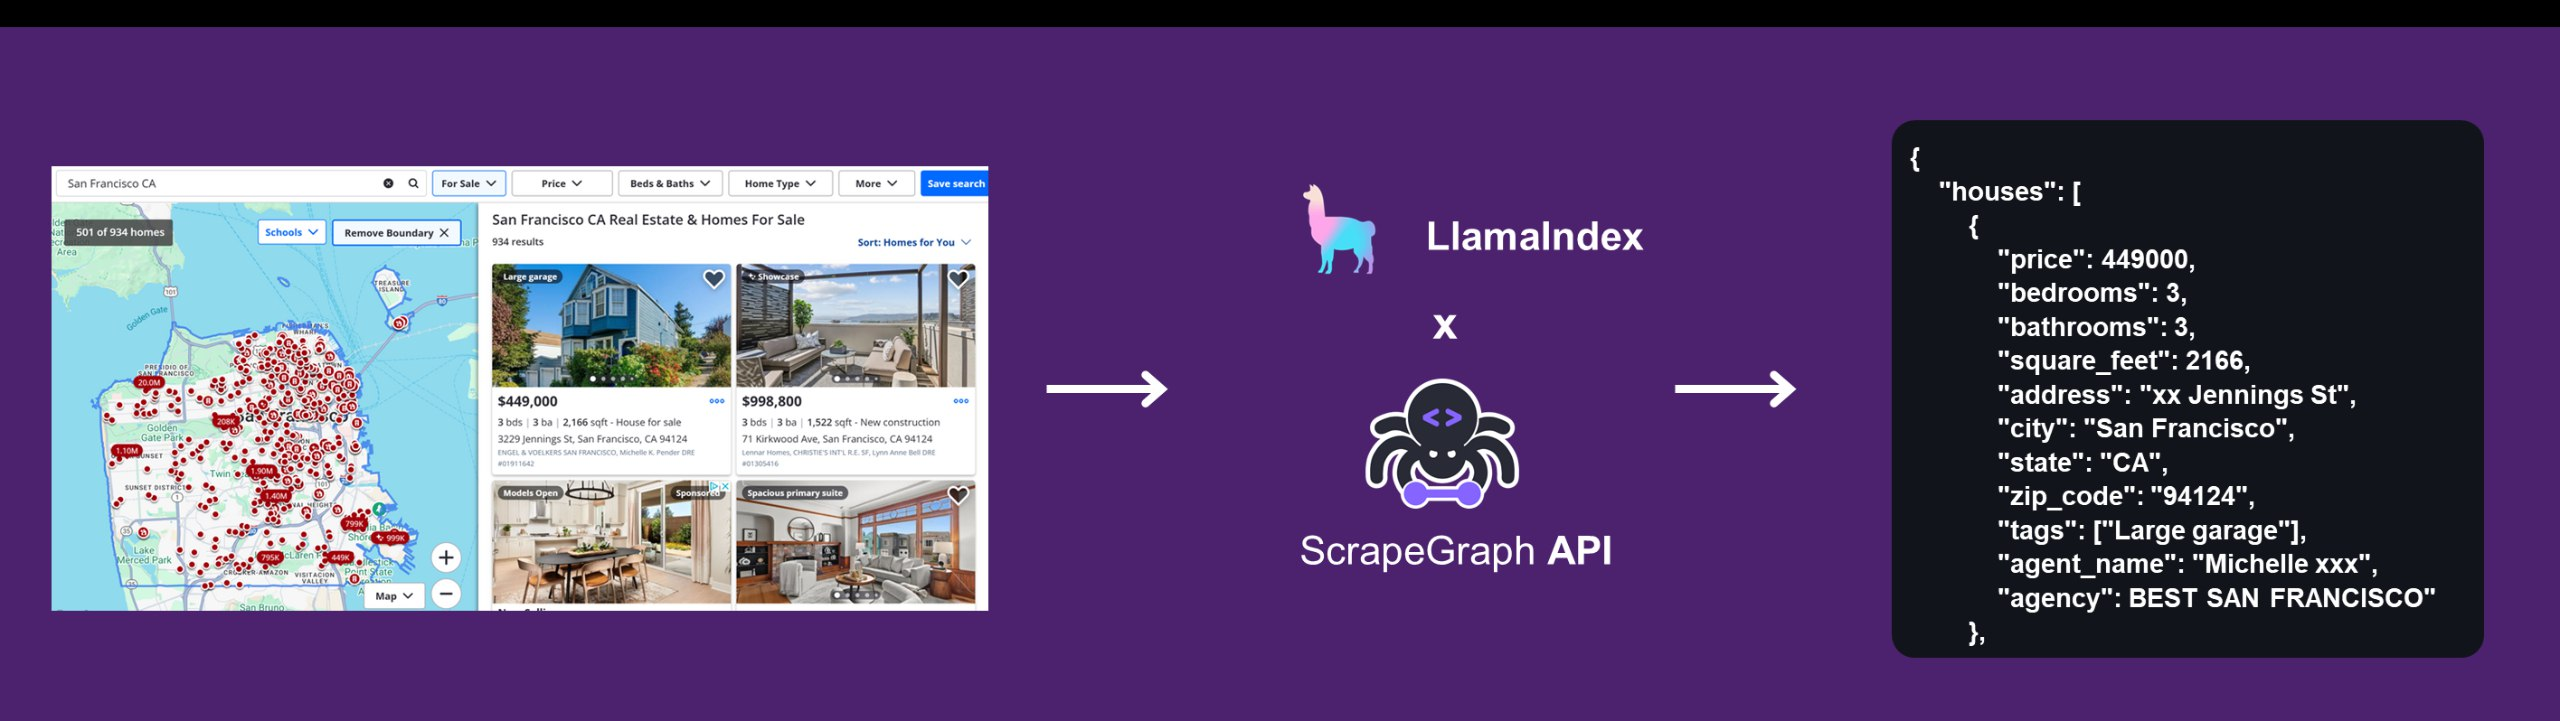

### 🔧 Install `dependencies`

In [ ]:
%%capture
!pip install llama-index
!pip install llama-index-tools-scrapegraphai

### 🔑 Import `ScrapeGraph` API key

You can find the Scrapegraph API key [here](https://dashboard.scrapegraphai.com/)

In [ ]:
import os
from getpass import getpass

# Check if the API key is already set in the environment
sgai_api_key = os.getenv("SGAI_API_KEY")

if sgai_api_key:
    print("SGAI_API_KEY found in environment.")
else:
    print("SGAI_API_KEY not found in environment.")
    # Prompt the user to input the API key securely (hidden input)
    sgai_api_key = getpass("Please enter your SGAI_API_KEY: ").strip()
    if sgai_api_key:
        # Set the API key in the environment
        os.environ["SGAI_API_KEY"] = sgai_api_key
        print("SGAI_API_KEY has been set in the environment.")
    else:
        print("No API key entered. Please set the API key to continue.")


SGAI_API_KEY not found in environment.
SGAI_API_KEY has been set in the environment.


### 📝 Defining an `Output Schema` for Webpage Content Extraction


If you already know what you want to extract from a webpage, you can **define an output schema** using **Pydantic**. This schema acts as a "blueprint" that tells the AI how to structure the response.

<details>
  <summary>Pydantic Schema Quick Guide</summary>

Types of Schemas  

1. Simple Schema  
Use this when you want to extract straightforward information, such as a single piece of content.  

```python
from pydantic import BaseModel, Field

# Simple schema for a single webpage
class PageInfoSchema(BaseModel):
    title: str = Field(description="The title of the webpage")
    description: str = Field(description="The description of the webpage")

# Example Output JSON after AI extraction
{
    "title": "ScrapeGraphAI: The Best Content Extraction Tool",
    "description": "ScrapeGraphAI provides powerful tools for structured content extraction from websites."
}
```

2. Complex Schema (Nested)  
If you need to extract structured information with multiple related items (like a list of repositories), you can **nest schemas**.

```python
from pydantic import BaseModel, Field
from typing import List

# Define a schema for a single repository
class RepositorySchema(BaseModel):
    name: str = Field(description="Name of the repository (e.g., 'owner/repo')")
    description: str = Field(description="Description of the repository")
    stars: int = Field(description="Star count of the repository")
    forks: int = Field(description="Fork count of the repository")
    today_stars: int = Field(description="Stars gained today")
    language: str = Field(description="Programming language used")

# Define a schema for a list of repositories
class ListRepositoriesSchema(BaseModel):
    repositories: List[RepositorySchema] = Field(description="List of GitHub trending repositories")

# Example Output JSON after AI extraction
{
    "repositories": [
        {
            "name": "google-gemini/cookbook",
            "description": "Examples and guides for using the Gemini API",
            "stars": 8036,
            "forks": 1001,
            "today_stars": 649,
            "language": "Jupyter Notebook"
        },
        {
            "name": "TEN-framework/TEN-Agent",
            "description": "TEN Agent is a conversational AI powered by TEN, integrating Gemini 2.0 Multimodal Live API, OpenAI Realtime API, RTC, and more.",
            "stars": 3224,
            "forks": 311,
            "today_stars": 361,
            "language": "Python"
        }
    ]
}
```

Key Takeaways  
- **Simple Schema**: Perfect for small, straightforward extractions.  
- **Complex Schema**: Use nesting to extract lists or structured data, like "a list of repositories."  

Both approaches give the AI a clear structure to follow, ensuring that the extracted content matches exactly what you need.
</details>


In [ ]:
from pydantic import BaseModel, Field
from typing import List

class HouseListingSchema(BaseModel):
    price: int = Field(description="Price of the house in USD")
    bedrooms: int = Field(description="Number of bedrooms")
    bathrooms: int = Field(description="Number of bathrooms")
    square_feet: int = Field(description="Total square footage of the house")
    address: str = Field(description="Address of the house")
    city: str = Field(description="City where the house is located")
    state: str = Field(description="State where the house is located")
    zip_code: str = Field(description="ZIP code of the house location")
    tags: List[str] = Field(description="Tags like 'New construction' or 'Large garage'")
    agent_name: str = Field(description="Name of the listing agent")
    agency: str = Field(description="Agency listing the house")

# Schema containing a list of house listings
class HousesListingsSchema(BaseModel):
    houses: List[HouseListingSchema] = Field(description="List of house listings on Zillow or similar platforms")


### 🚀 Initialize `ScrapegraphToolSpec` tools and start extraction

Here we use `SmartScraperTool` to extract structured data using AI from a webpage.


> If you already have an HTML file, you can upload it and use `LocalScraperTool` instead.

You can find more info in the [official langchain documentation](https://python.langchain.com/docs/integrations/tools/scrapegraph/)



In [ ]:
from llama_index.tools.scrapegraph.base import ScrapegraphToolSpec

scrapegraph_tool = ScrapegraphToolSpec()

`Invoke` the tool

In [ ]:
response = scrapegraph_tool.scrapegraph_smartscraper(
    prompt="Extract information about houses for sale",
    url="https://www.zillow.com/san-francisco-ca/",
    api_key=os.getenv("SGAI_API_KEY"),
    schema=HousesListingsSchema,
)

> As you may have noticed, we are not passing the `llm_output_schema` while invoking the tool, this will make life easier to `AI agents` since they will not need to generate one themselves with high risk of failure. Instead, we force the tool to return always a structured output that follows your previously defined schema. To find out more, check the following [README](https://github.com/ScrapeGraphAI/langchain-scrapegraph)


Print the response

In [ ]:
import json

print("Trending Repositories:")
print(json.dumps(response, indent=2))

Trending Repositories:
{
  "request_id": "628bdf64-26f9-486a-9f2f-f3b5ac9c0421",
  "status": "completed",
  "website_url": "https://www.zillow.com/san-francisco-ca/",
  "user_prompt": "Extract information about houses for sale",
  "result": {
    "houses": [
      {
        "price": 449000,
        "bedrooms": 3,
        "bathrooms": 3,
        "square_feet": 2166,
        "address": "3229 Jennings St",
        "city": "San Francisco",
        "state": "CA",
        "zip_code": "94124",
        "tags": [],
        "agent_name": "Michelle K. Pender",
        "agency": "ENGEL & VOELKERS SAN FRANCISCO"
      },
      {
        "price": 950000,
        "bedrooms": 2,
        "bathrooms": 2,
        "square_feet": 1686,
        "address": "401 Huron Ave",
        "city": "San Francisco",
        "state": "CA",
        "zip_code": "94112",
        "tags": [
          "Cozy fireplace"
        ],
        "agent_name": "Allison Chapleau",
        "agency": "COMPASS"
      },
      {
        "pr

### 💾 Save the output to a `CSV` file

Let's create a pandas dataframe and show the table with the extracted content

In [ ]:
import pandas as pd

# Convert dictionary to DataFrame
df = pd.DataFrame(response["result"]["houses"])
df

,price,bedrooms,bathrooms,square_feet,address,city,state,zip_code,tags,agent_name,agency
0,449000,3,3,2166,3229 Jennings St,San Francisco,CA,94124,[],Michelle K. Pender,ENGEL & VOELKERS SAN FRANCISCO
1,950000,2,2,1686,401 Huron Ave,San Francisco,CA,94112,[Cozy fireplace],Allison Chapleau,COMPASS
2,207555,1,1,1593,2040 Fell St APT 10,San Francisco,CA,94117,[],Trista Elizabeth Bernasconi,COMPASS
3,795000,4,2,2000,515 Athens St,San Francisco,CA,94112,[Level fenced rear yard],Darin J. Holwitz,COMPASS
4,599000,1,1,0,380 Dolores St #6,San Francisco,CA,94114,[],Melody A. Hultgren,NOVA REAL ESTATE
5,875000,2,2,907,426 Fillmore St #A,San Francisco,CA,94117,[Sleek finishes],NA,NA
6,335512,2,2,886,1688 Pine St #101,San Francisco,CA,94109,[],Trista Elizabeth Bernasconi,COMPASS
7,899000,4,2,1680,351 Chenery St,San Francisco,CA,94131,[South-facing panoramic views],Easton S. Thodos,THESEUS REAL ESTATE
8,155659,0,1,514,52 Kirkwood Ave #203,San Francisco,CA,94124,[Modern cabinetry],Lynn Anne Bell,CHRISTIE'S INT'L R.E. SF


Save it to CSV

In [ ]:
# Save the DataFrame to a CSV file
csv_file = "zillow_forsale.csv"
df.to_csv(csv_file, index=False)
print(f"Data saved to {csv_file}")

## 🔗 Resources


<p align="left">
  <img src="https://raw.githubusercontent.com/VinciGit00/Scrapegraph-ai/main/docs/assets/api-banner.png"
       alt="ScrapeGraph API Banner" width="600">
</p>


- 🚀 **Get your API Key:** [ScrapeGraphAI Dashboard](https://dashboard.scrapegraphai.com)  
- 🐙 **GitHub:** [ScrapeGraphAI GitHub](https://github.com/scrapegraphai)  
- 💼 **LinkedIn:** [ScrapeGraphAI LinkedIn](https://www.linkedin.com/company/scrapegraphai/)  
- 🐦 **Twitter:** [ScrapeGraphAI Twitter](https://twitter.com/scrapegraphai)  
- 💬 **Discord:** [Join our Discord Community](https://discord.gg/uJN7TYcpNa)  
- 🦙 **LlamaIndex:** [ScrapeGraph docs](https://docs.llamaindex.ai/en/stable/api_reference/tools/scrapegraph/)

Made with ❤️ by the [ScrapeGraphAI](https://scrapegraphai.com) Team  
